In [1]:
import influxdb 
import pandas as pd
from dateutil import tz

# import the libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%matplotlib inline

import pandas as pd
import numpy as np
from pipedream_solver.hydraulics import SuperLink
from pipedream_solver.simulation import Simulation

import seaborn as sns
sns.set_palette('husl')




# Real-time Waller Creek simulation

## set up Waller Creek model 

In [2]:
################# set up Waller creek model################### 
subbasins = pd.read_excel('Waller_HMS_model_data.xlsx', sheet_name=0)
reservoirs = pd.read_excel('Waller_HMS_model_data.xlsx', sheet_name=1)
nodes = pd.read_excel('Waller_HMS_model_data.xlsx', sheet_name=2)
reaches = pd.read_excel('Waller_HMS_model_data.xlsx', sheet_name=3)

cross_section=pd.read_excel('/Users/future_water_system/Desktop/Data/reach_cross_section_info.xlsx')
shp = gpd.read_file('/Users/future_water_system/Desktop/Data/Waller_Creek_Segments/')

ft_to_m = 0.3048
M = len(reservoirs) + len(nodes)
K = len(reaches)

superjunctions = pd.DataFrame(np.arange(M), columns=['id'])
superlinks = pd.DataFrame(np.arange(K), columns=['id'])

superjunctions['name'] = nodes['Name'].tolist() + reservoirs['Name'].tolist()
superlinks['name'] = reaches['Name'].tolist()

superjunctions.set_index('name', drop=True, inplace=True)
superlinks.set_index('name', drop=True, inplace=True)

shp_subset = shp.dropna(subset=['REACH_NAME'])
reaches_haslen = reaches.dropna(subset=['Length (FT)'])
reaches_shapelen = reaches.dropna(subset=['Shape Length'])

nodes_subset = nodes[nodes['Downstream'].isin(superlinks.index.values)]
reservoirs_subset = reservoirs[reservoirs['Downstream'].isin(superlinks.index.values)]

upstream_nodes = (nodes_subset.set_index('Downstream')
                  .reindex(superlinks.index.values).dropna(subset=['Name'])['Name'])

upstream_reservoirs = (reservoirs_subset.set_index('Downstream')
                       .reindex(superlinks.index.values).dropna(subset=['Name'])['Name'])

reaches.index = reaches['Name']

######## Remove the unnecessary reaches########## 
# Remove Reilly pond
upstream_reservoirs.loc['R_WLR06'] = 'J_WLR06_US_POND_REILLY'
# Remove Central park pond
reaches.loc['R_HEM04', 'Downstream'] = 'J_HEM04_COMB_AT_38TH'
# Remove another node with no downstream reach
reaches.loc['R_HEM03', 'Downstream'] = 'J_HEM04_COMB_AT_38TH'
# Remove another disconnected node
reaches.loc['R_WLR19', 'Downstream'] = 'J_WLR23_12TH'
# Remove
reaches.loc['R_WLR04', 'Downstream'] = 'J_WLR05_COMB_AT_HUNTLAND'
# Remove
reaches.loc['R_HEM07', 'Downstream'] = 'J_WLR18_COMB_HEMP'
# Remove00
reaches.loc['R_WLR10', 'Downstream'] = 'J_WLR12_COMB_AT_DUVAL'
# Remove
reaches.loc['R_WLR15', 'Downstream'] = 'J_WLR18_COMB_HEMP'

############## initalized the conditions################# 

outfall = {'id' : len(superjunctions), 'z_inv' : 130., 'h_0' : 1e-5,
           'bc' : True, 'storage' : 'functional', 'a' : 0., 'b' : 0.,
           'c' : 100., 'max_depth' : np.inf}

superjunctions.loc[nodes['Name'].values, 'z_inv'] = ft_to_m * nodes.set_index('Name')['Lowest elevation'].values
superjunctions['h_0'] = 1e-5
superjunctions['bc'] = False
superjunctions['storage'] = 'functional'
superjunctions['a'] = 0.
superjunctions['b'] = 0.
superjunctions['c'] = 100.
superjunctions['max_depth'] = np.inf
superjunctions.loc['OUT_COLORADO_RIVER'] = outfall

superjunctions = (superjunctions.drop('POND_REILLY')
                  .drop('POND_CENTRAL_PARK')
                  .drop('J_HEM02_38TH')
                  .drop('J_WLR22_US_of_12TH')
                  .drop('J_WLR04_TRIB_AT_HUNTLAND')
                  .drop('J_HEM07_DEAN_KEETON')
                  .drop('J_WLR11_MAIN_AT_DUVAL')
                  .drop('J_WLR17_DEAN_KEETON'))
superjunctions['id'] = np.arange(len(superjunctions))


superlinks['sj_0'] = -1
superlinks.loc[upstream_nodes.index.values, 'sj_0'] = superjunctions.loc[upstream_nodes.values, 'id'].values
superlinks.loc[upstream_reservoirs.index.values, 'sj_0'] = superjunctions.loc[upstream_reservoirs.values, 'id'].values
superlinks['sj_1'] = superjunctions.loc[reaches['Downstream'].values, 'id'].values
superlinks['in_offset'] = 0.
superlinks['out_offset'] = 0.
#superlinks.loc[shp_subset['REACH_NAME'].values, 'dx'] = ft_to_m * shp_subset['Shape_Leng'].values
superlinks.loc[reaches_haslen['Name'].values, 'dx'] = ft_to_m * reaches_haslen['Length (FT)'].values
superlinks.loc[reaches_shapelen['Name'].values, 'dx'] = ft_to_m * reaches_shapelen['Shape Length'].values
superlinks['n'] = 0.083
superlinks.loc[reaches_haslen['Name'].values, 'n'] = reaches_haslen["Manning's n"].values
superlinks['shape'] = 'rect_open'
superlinks['g1'] = 10.
superlinks['g2'] = 5.
superlinks['g3'] = 0.
superlinks['g4'] = 0.
superlinks['Q_0'] = 0.
superlinks['h_0'] = 1e-5
superlinks['ctrl'] = False
superlinks['A_s'] = 1.
superlinks['A_c'] = 0.
superlinks['C'] = 0.

####################### set up additional conditions####################### 
R_WLR01 = reaches.set_index('Name').loc['R_WLR01']
z_inv_upstream_waller = (0.3048 * R_WLR01['Length (FT)'] * R_WLR01['Slope (FT/FT)'] 
                         + superjunctions.iloc[superlinks.loc['R_WLR01', 'sj_1']]['z_inv'])

R_HEM02 = reaches.set_index('Name').loc['R_HEM02']
z_inv_triangle_pond = (0.3048 * R_HEM02['Length (FT)'] * R_HEM02['Slope (FT/FT)'] 
                           + superjunctions.iloc[superlinks.loc['R_HEM02', 'sj_1']]['z_inv'])

R_HEM01 = reaches.set_index('Name').loc['R_HEM01']
z_inv_upstream_hemphill = (0.3048 * R_HEM01['Length (FT)'] * R_HEM01['Slope (FT/FT)'] 
                           + z_inv_triangle_pond)

upstream_waller = {'id' : len(superjunctions), 'z_inv' : z_inv_upstream_waller, 'h_0' : 1e-5,
                   'bc' : False, 'storage' : 'functional', 'a' : 0., 'b' : 0.,
                   'c' : 100., 'max_depth' : np.inf}

upstream_hemphill = {'id' : len(superjunctions) + 1, 'z_inv' : z_inv_upstream_hemphill, 'h_0' : 1e-5,
                   'bc' : False, 'storage' : 'functional', 'a' : 0., 'b' : 0.,
                   'c' : 100., 'max_depth' : np.inf}

superjunctions.loc['UPSTREAM_WALLER'] = upstream_waller
superjunctions.loc['UPSTREAM_HEMPHILL'] = upstream_hemphill
superjunctions.loc['POND_TRIANGLE', 'z_inv'] = z_inv_triangle_pond 

superlinks.loc['R_WLR01', 'sj_0'] = superjunctions.loc['UPSTREAM_WALLER', 'id']
superlinks.loc['R_HEM01', 'sj_0'] = superjunctions.loc['UPSTREAM_HEMPHILL', 'id']
superlinks.loc['R_WLR22', 'sj_0'] = superjunctions.loc['J_WLR25_9TH_COMB_SEWER', 'id']
superlinks.loc['R_WLR24', 'sj_0'] = superjunctions.loc['J_WLR28_CESAR_CHAVEZ', 'id']

superjunctions = superjunctions.reset_index()
superlinks = superlinks.reset_index()
superjunctions.loc[superlinks[~superlinks['sj_1'].isin(superlinks['sj_0'])]['sj_1'].values]

#superjunctions.to_csv('waller_superjunctions.csv')
#superlinks.to_csv('waller_superlinks.csv')

#superjunctions.loc['POND_REILLY', 'z_inv'] = superjunctions.loc['J_WLR06_US_POND_REILLY', 'z_inv']
#superjunctions.loc['POND_CENTRAL_PARK', 'z_inv'] = superjunctions.loc['J_HEM04_COMB_AT_38TH', 'z_inv']

################set up cross section information ###################
#exclusive= np.setxor1d(cross_section['reach_name'].values, superlinks.index.values)
#exclusive        

superlinks['shape'] = 'Trapezoidal' 
superlinks.index=superlinks['name']

superlinks.loc[cross_section['reach_name'].values,'g1']=cross_section.set_index('reach_name')['y'].values *ft_to_m
superlinks.loc[cross_section['reach_name'].values,'g2']=cross_section.set_index('reach_name')['Bw'].values *ft_to_m
superlinks.loc[cross_section['reach_name'].values,'g3']=1/(cross_section.set_index('reach_name')['z'].values*ft_to_m)

superlinks.loc[['R_HEM01','R_HEM02','R_HEM03','R_HEM04','R_HEM05'],['g1','g2','g3']]=superlinks.loc['R_HEM06',['g1','g2','g3']].values
superlinks.loc[['R_WLR01','R_WLR02'],['g1','g2','g3']]=superlinks.loc['R_WLR03',['g1','g2','g3']].values
superlinks.loc[['R_WLR04'],['g1','g2','g3']]=superlinks.loc['R_WLR05',['g1','g2','g3']].values
superlinks.loc[['R_WLR21'],['g1','g2','g3']]=superlinks.loc['R_WLR20',['g1','g2','g3']].values

superlinks.index=superlinks['id']
#superlinks.to_csv('superlinks_cross_section_updated.csv')

########### definition to calulate Q_in ################

def cal_pervious_CN(CN_C, A_Imp): #calculate pervious CN
    ###########initial value setting########## 
    CN_C=CN_C
    A_Imp=A_Imp
    pre_x = np.array([A_Imp]).reshape((-1, 1))
    ##########################################

    # Create a numpy array of data:
    x = np.array([0, 100]).reshape((-1, 1)) # Impervious area
    y = np.array([CN_C, 99]) #Pervious CN (CN_P)

    # Create an instance of a linear regression model and fit it to the data with the fit() function:
    model = LinearRegression().fit(x, y) 

    # Predict a Response and print it:
    y_pred = model.predict(pre_x)
    
    return y_pred


def cal_excess_precip(Precip, unit_hy, CN, Area): #runoff calculation of each subbasins
    Sub_Area=Area
    P=Precip
    CN=CN
    unit_hy=unit_hy
    S = 1000 / CN - 10
    Ia = 0.2 * S

    # Excess precipitation
    Pes = []
    # Infiltration
    Fas = []
    P_now=0
    num=int(len(P))
    for t in range(0,num):
        Pt = P[t]
        P_now=Pt+P_now

        if P_now <= Ia:
            Pe = 0.
        else:        
            Pe = (P_now - 0.2 * S)**2 / (P_now + 0.8 * S)
            Pe=Pe[0]
            
            #Fa = P_now - Pe - Ia

        Pes.append(Pe)
       # Fas.append(Fa)

    Pes = np.array(Pes)
    #Fas = np.array(Fas)

    #unit hydrograph

    unit_hy2=unit_hy/sum(unit_hy)

    #convolution excess and unit_hydrograph
    cov=np.convolve(np.diff(Pes),unit_hy2)
    
    #convert to outflow 
    Area_MI2=Sub_Area
    Area_ft=Area_MI2*2.788*10**7
    Pes_ft=np.diff(Pes)/12
    cov_ft=cov/12
    outflow =(cov_ft*Area_ft)/120 
    return Pes, outflow



## Pipedream Simulation 

In [3]:
############### import actual Rain data for a simulation ############### 
#output = pd.read_csv('WLR01_output.csv') #scs_storm_10%
#Precip = output['Precip']
#output = pd.read_csv('/Users/future_water_system/Desktop/Data/precipitation_scs_storm_50_-_Sheet1.csv')
#Precip = output['precipitation']

##### read USGS previous Rain data 
#output = pd.read_excel('/Users/future_water_system/Desktop/Data/rainfall data/rainfall_0728-0902_USGS_302814097444799.xlsx') 
output = pd.read_excel('/Users/future_water_system/Desktop/Data/rainfall data/rainfall_0627-0628_USGS_302814097444799.xlsx') 
#output=output[output['date']=='2022-08-18']
#output1=output[output['date']=='2022-08-22']
#output2=output[output['date']=='2022-08-23']
#output=pd.concat([output1,output2])
output=output.reset_index(drop=True)
output

##### set date and time data to datetime info 
for i in range(0, len(output['time'])):
    d=int(round(output['date'][i].timestamp()))
    h=int(output['time'][i].strftime("%H"))*60*60
    m=int(output['time'][i].strftime("%M"))*60
    s=int(output['time'][i].strftime("%S"))
    datetime=d+h+m+s
    output['time'][i]=pd.to_datetime(datetime * 1e9)
    

###### interpolation the precipitation information 
Precip=output.set_index('time').resample('15min').mean().interpolate()
Precip = Precip['precipitation']
#Precip=Precip['20220818 01:00:00' :  '20220818 22:30:00'] 


/Users/yeji/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


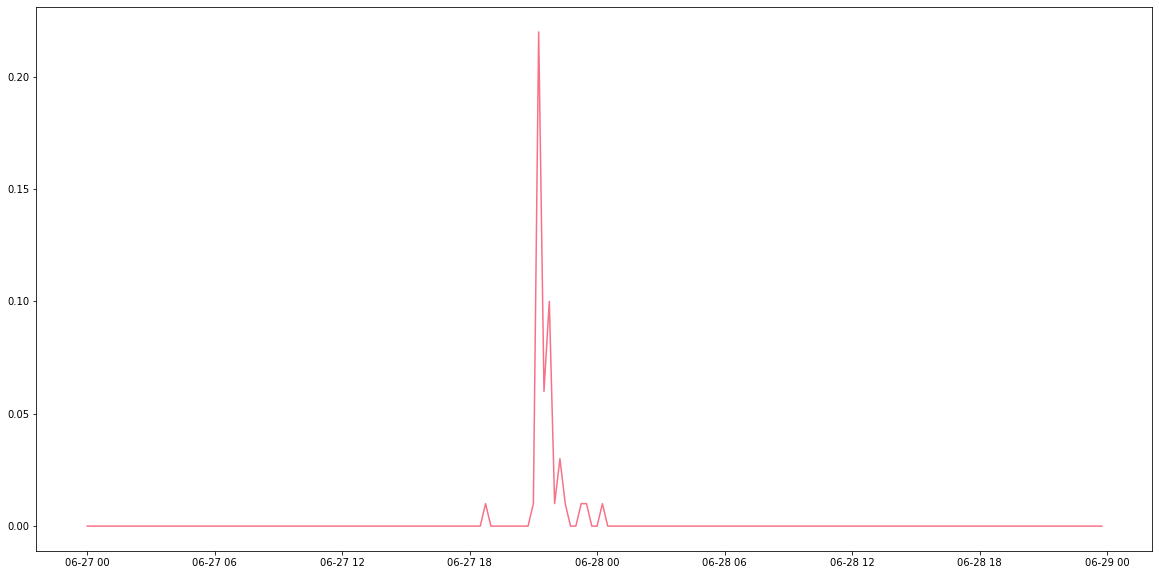

In [4]:
plt.figure(figsize=(20, 10))
plt.plot(Precip)

In [5]:


##### interpolate the unit hydrograph
df = pd.read_csv('unit hydrograph.csv')

lag_time =26. # minutes
df['time'] = df['time ratios'] * lag_time * 60 * 1e9
df['time'] = pd.to_datetime(df['time'])
hydrograph=df.set_index('time').resample('15min').mean().interpolate()
unit_hy=hydrograph['discharge ratios']


############calculate Q_in (outflow) of each subbasins#########

Q_in=pd.DataFrame(columns=superjunctions['name'])
for i in range(0,len(subbasins)):
    CN_C= subbasins['Curve Number'][i]
    A_Imp= subbasins['Impervious Percent'][i]
    Area= subbasins['Area (mi2)'][i]
    Downstream= subbasins['Downstream'][i]
    CN_P=cal_pervious_CN(CN_C, A_Imp)
    CN = CN_P
    
    Pes, outflow=cal_excess_precip(Precip, unit_hy, CN, Area)
    
    #save outflow in Q_in dataframe
   
    if Downstream == 'R_WLR01': 
        Q_in['UPSTREAM_WALLER']=outflow
    elif Downstream == 'R_HEM01': 
        Q_in['UPSTREAM_HEMPHILL']=outflow
    else : Q_in[Downstream]=outflow
        

### drop the subbasins that don't have Q_in data     
exclusive= np.setxor1d(subbasins['Downstream'].values, Q_in.columns)
a = np.array(['R_WLR01','R_HEM01'])
exclusive= np.setxor1d(exclusive,a )
Q_in=Q_in.drop(columns=exclusive)

Q_in=Q_in.fillna(0.)

####time change min to sec : 15 min(precipitation interval) *60 sec 
Q_in.index=15*60*Q_in.index

# change unit of Q_in to input to the model 
Q_in = Q_in*ft_to_m*ft_to_m*ft_to_m # chage unit (cfs to m^3/s)

In [ ]:
############## Instantiate superlink model############
superlink = SuperLink(superlinks, superjunctions,internal_links=30)
H=[]
Ik=[]
# Set constant timestep (in seconds)
dt =2
t_end = Q_in.index[-1]

############## Create simulation context manager##########
with Simulation(superlink, Q_in=Q_in, t_end=t_end ) as simulation:
    # While simulation time has not expired...
    while simulation.t <= simulation.t_end:
        # Step model forward in time
        simulation.step(dt=dt)
        # Record internal depth and flow states
        simulation.record_state()
        # Print progress bar
        simulation.print_progress()
        H.append(superlink.H_j.copy())
        Ik.append(superlink.h_Ik.copy())
H = np.vstack(H)
Ik = np.vstack(Ik)

[--------------------------------------------------] 0.0% [1.76 s]

In [ ]:
plt.plot(Q_in)

In [ ]:

num1=len(Precip)
num2=len(unit_hy)
if num1<num2:
    num=num2
elif num2<num1:
    num=num1

In [ ]:
(t_end/60/15)-num

In [ ]:
after=((t_end/60/15)-num)*60*15


In [ ]:
#Simulation result: J_WLR18_COMB_HEMP (id: 14)
a=(H - superlink.z_inv_j)
#plt.plot(a[:7200,14])

#real-time graph?
#after=15*60*(len(unit_hy-2)) # 15min *60 * (len(unit_hy)-1)
n=len(a)- after
n=len(a)
n0=90*60
x_t=(n-n0+1)/60/60
x=np.linspace(0,x_t,n-n0) 

start = pd.Timestamp('20220627 00:00:00',tz='Etc/GMT')
end = pd.Timestamp('20220628 23:00:00',tz='Etc/GMT')
t = np.linspace(start.value, end.value, n-n0)
t = pd.to_datetime(t)

plt.figure(figsize=(20, 10))
plt.plot(t,a[n0:n,14])

plt.title('Pipedream modeling', fontsize=28)
plt.ylabel('Depth(m)',fontsize=24)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

In [ ]:
t_end 

# Real-time Waller Creek monitoring 

In [ ]:
# Visualizing the actual depth of Waller Creeks  

# set up the lists(node_id and length between node and bottom)
node_id_list=['Bridge1','Bridge2','Bridge3','Bridge4','Bridge5']
length_ntb_list =[3911.6, 3175, 4927.6, 4978.4, 3556]
ntb_df=pd.DataFrame(length_ntb_list, columns=['depth'])
ntb_df=ntb_df.set_index([node_id_list])

#set up the influxDBClient 
client_dict = {'host' : 'ec2-3-91-156-8.compute-1.amazonaws.com',
               'port' : 8086,
               'username' : 'generic_node',
               'password' : 'GlareShellTwilight',
               'database' : 'RAW'}

client = influxdb.InfluxDBClient(**client_dict)

# definition of query to call influxdb data
def run_query(client, field, measurement, tags, pagesize=10000):
    
    #select the length of node to bottom  
    length_ntb=ntb_df.at[tags['node_id'],'depth']
    
    collect = []
    times = []
    values = []
    q = True
    pagenum = 0
    # Single quotes around tags might not always work
    tag_str = ' AND '.join(["{key}='{value}'".format(key=key, value=value) for key, value
                            in tags.items()])
    
    
    while q:
        q = client.query(("SELECT {field} FROM {measurement} WHERE {tags} "
                          "LIMIT {pagesize} OFFSET {page}")
                          .format(field=field, measurement=measurement, tags=tag_str,
                                  pagesize=pagesize, page=pagenum*pagesize))
        if q:
            collect.append(q[measurement])
           
        pagenum += 1
    for resultset in collect:
        for reading in resultset:
            
            #######time variable##########
            dt_gmt=pd.Timestamp(reading['time'],tz='Etc/GMT')
            
            #update time of data with local time zone 
            #difference_time =pd.Timestamp(reading['time'],tz='GMT')
            #local_time = dt_gmt +
            times.append(dt_gmt)
            
            #local_zone=tz.tzlocal() 
            #local_dt=dt_gmt.astimezone(local_zone)
            #times.append(local_dt)
            ################################
            values.append((length_ntb-reading[field])*0.001)
    s = pd.Series(values, index=times)
    
    s.index = pd.to_datetime(s.index)
    
    
    drop_index=s[s<=0].index
    s=s.drop(index=drop_index)


    return s




In [ ]:
s = run_query(client, 'value', 'depth', {'node_id' : 'Bridge3'})

s.loc['20220627 00:00:00':'20220628 23:00:00'].plot(style='o-', figsize=(20, 10))
plt.title('Sensor node monitoring', fontsize=28)
plt.ylabel('Depth(m)',fontsize=24)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18, rotation=0)
plt.show()

# Comparision of modeling and monitoring data 

In [ ]:
simulation.step

In [ ]:
unit_hy

In [ ]:
#Simulation result: J_WLR18_COMB_HEMP (id: 14)
a=(H - superlink.z_inv_j)
#plt.plot(a[:7200,14])

#####################real-time graph?#################
after=15*60*(len(unit_hy)-2) # 15min *60 * (len(unit_hy)-1)
n=len(a)- after
n0=90*60
x_t=(n-n0+1)/60/60
x=np.linspace(0,x_t,n-n0) 
####################################################
start = pd.Timestamp('20220627 00:00:00',tz='Etc/GMT')
end = pd.Timestamp('20220628 23:00:00',tz='Etc/GMT')
#t = np.linspace(start.value, end.value, n-n0)


t1 = np.linspace(start.value, end.value,len(a[n0:n,14]))
t1 = pd.to_datetime(t1)

plt.figure(figsize=(20, 10))
#plt.plot(t,a[n0:n,14])
plt.plot(t1,a[n0:n,14], label='Pipedream modeling')

s = run_query(client, 'value', 'depth', {'node_id' : 'Bridge5'})
x1=s['20220627 00:00:00':'20220628 23:00:00']
t_b5 =s['20220627 00:00:00':'20220628 23:00:00'].index-pd.Timedelta('05:00:00')
plt.plot(t_b5,x1,'o-', label='Sensor monitoring')

plt.legend(fontsize=20)
plt.ylabel('Depth(m)',fontsize=23)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()                                                      


In [ ]:
a[n0:n,14]

# Comparision of modeling and monitoring data and LCRA data


In [ ]:
# Add LCRA data (Flow data for the 'Waller Creek at 23rd Street' gage from the LCRA site.)
LCRA = pd.read_excel('/Users/future_water_system/Desktop/Data/LCRA_discharge/W3A_Export.xlsx')
LCRA=LCRA[8:]
LCRA=LCRA.set_index('Site Name')

ft_to_m = 0.3048

all_water_level =LCRA['2022-06-27 00:00:00':'2022-08-28 23:00:00']['W3A']
all_flow_rate=LCRA['2022-06-27 00:00:00':'2022-08-28 23:00:00']['W3A.1']
#W3A water level, W3A.1 flow rate, W3A.3 rainfall
water_level=LCRA['2022-06-27 00:00:00':'2022-06-28 23:00:00']['W3A']
flow_rate=LCRA['2022-06-27 00:00:00':'2022-06-28 23:00:00']['W3A.1']
rainfall=LCRA['2022-06-27 00:00:00':'2022-06-28 23:00:00']['W3A.3']

#Drop the nan value
water_level_ft=water_level.dropna()
flow_rate_ft=flow_rate.dropna()
rainfall=rainfall.dropna()

all_water_level_ft=all_water_level.dropna()
all_flow_rate_ft=all_flow_rate.dropna()


water_level_m=water_level_ft * ft_to_m
flow_rate_m=flow_rate_ft* ft_to_m**3

all_water_level_m=all_water_level_ft * ft_to_m
all_flow_rate_m=all_flow_rate_ft* ft_to_m**3

In [ ]:

#Simulation result: J_WLR18_COMB_HEMP (id: 14)
a=(H - superlink.z_inv_j)
#plt.plot(a[:7200,14])

#####################real-time graph?#################
after=15*60*(len(unit_hy)-2) # 15min *60 * (len(unit_hy)-1)
n=len(a)- after
n0=90*60
x_t=(n-n0+1)/60/60
x=np.linspace(0,x_t,n-n0) 
####################################################


plt.figure(figsize=(20, 10))
#graph LCRA data 
t_lc=water_level_m.index
t_lc = pd.to_datetime(t_lc) # change to utc/gmt+5
plt.plot(t_lc,water_level_m,'o-', label='LCRA data')

#graph pipedream modeling 
start = pd.Timestamp('20220627 00:00:00',tz='Etc/GMT')
end = pd.Timestamp('20220628 23:00:00',tz='Etc/GMT')

t1 = np.linspace(start.value, end.value,len(a[n0:n,14]))
t1 = pd.to_datetime(t1)

plt.plot(t1,a[n0:n,14], label='Pipedream modeling')


# graph Monitoring data (ultrasonic sensor nodes)
# used run_query to call the data from influxdb
s = run_query(client, 'value', 'depth', {'node_id' : 'Bridge5'})
x_b5=s['20220627 00:00:00':'20220628 23:00:00']
t_b5 =s['20220627 00:00:00':'20220628 23:00:00'].index
t_b5 = pd.to_datetime(t_b5)-pd.Timedelta('05:00:00')
plt.plot(t_b5,x_b5,'o-', label='Sensor monitoring (Bridge5)')

s = run_query(client, 'value', 'depth', {'node_id' : 'Bridge4'})
x_b4=s['20220627 00:00:00':'20220628 23:00:00']
t_b4 =s['20220627 00:00:00':'20220628 23:00:00'].index
t_b4 = pd.to_datetime(t_b4)-pd.Timedelta('05:00:00')
plt.plot(t_b4,x_b4,'o-', label='Sensor monitoring (Bridge4)')

s = run_query(client, 'value', 'depth', {'node_id' : 'Bridge3'})
x_b3=s['20220627 00:00:00':'20220628 23:00:00']
t_b3 =s['20220627 00:00:00':'20220628 23:00:00'].index
t_b3 = pd.to_datetime(t_b3)-pd.Timedelta('05:00:00')
plt.plot(t_b3,x_b3,'o-', label='Sensor monitoring (Bridge3)')

#s = run_query(client, 'value', 'depth', {'node_id' : 'Bridge2'})
#x_b2=s['20220627 00:00:00':'20220628 23:00:00']
#t_b2 =s['20220627 00:00:00':'20220628 23:00:00'].index
#plt.plot(t_b2,x_b2,'o-', label='Sensor monitoring (Bridge2)')

#s = run_query(client, 'value', 'depth', {'node_id' : 'Bridge1'})
#x_b1=s['20220627 00:00:00':'20220628 23:00:00']
#t_b1 =s['20220627 00:00:00':'20220628 23:00:00'].index
#plt.plot(t_b1,x_b1,'o-', label='Sensor monitoring (Bridge1)')


plt.legend(fontsize=20)
plt.ylabel('Depth(m)',fontsize=23)
plt.yticks(fontsize=20)

plt.xticks(fontsize=20)
plt.show()                                                      



In [ ]:
# Plot flow rate (cms)


# Compute average discharge in superlinks
simulation.states.Q_k = (simulation.states.Q_uk + simulation.states.Q_dk) / 2

# Plot results
#simulation.Q_in[['A', 'C']].plot( title='Input discharge (cms)')
#simulation.H_bc[['D', 'F']].plot( title='Boundary stage (m)')
discharge_graphs=simulation.states.Q_k
discharge = discharge_graphs['R_WLR16']
gap=len(discharge_graphs)

plt.figure(figsize=(20, 10))

t_lc=flow_rate_m.index
t_lc = pd.to_datetime(t_lc) # change to utc/gmt+5
plt.plot(t_lc,flow_rate_m,'o-', label='LCRA data')


#graph pipedream modeling 
start = pd.Timestamp('20220627 00:00:00',tz='Etc/GMT')
end = pd.Timestamp('20220628 23:00:00',tz='Etc/GMT')

t1 = np.linspace(start.value, end.value,len(discharge))
t1 = pd.to_datetime(t1)

plt.plot(t1,discharge, label='Pipedream modeling')

plt.legend(fontsize=20)
plt.ylabel('Flow rate(cms)',fontsize=23)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)



In [ ]:
len(t_lc)

In [ ]:

#superjunctions.to_csv('waller_creek_superjuctions.csv')

In [ ]:
#superjunctions.to_csv('waller_creek_superjuctions.csv')
#superlinks.to_csv('waller_creek_superlinks.csv')

# Calibration

In [ ]:
import numpy as np
import scipy.interpolate
from numba import njit
from numba.types import float64, int64, uint32, uint16, uint8, boolean, UniTuple, Tuple, List, DictType, void


In [ ]:
@njit(float64(float64, float64, float64, float64, float64),
      cache=True)
def Trapezoidal_A_ik(h_Ik, h_Ip1k, g1, g2, g3):
    """
    Compute cross-sectional area of flow for link i, superlink k.
    Inputs:
    -------
    h_Ik: np.ndarray
        Depth at upstream junction (meters)
    h_Ip1k: np.ndarray
        Depth at downstream junction (meters)
    g1: np.ndarray
        Height of channel (meters)
    g2: np.ndarray
        Width of channel (meters)
    g3: np.ndarray
        Inverse slope of channel sides (run/rise)
    """
    y_max = g1
    b = g2
    m = g3
    y = (h_Ik + h_Ip1k) / 2
    if y < 0:
        y = 0
    if y > y_max:
        y = y_max
    A = y * (b + m * y)
    return A

@njit(float64(float64, float64, float64, float64, float64),
      cache=True)
def Trapezoidal_Pe_ik(h_Ik, h_Ip1k, g1, g2, g3):
    """
    Compute perimeter of flow for link i, superlink k.
    Inputs:
    -------
    h_Ik: np.ndarray
        Depth at upstream junction (meters)
    h_Ip1k: np.ndarray
        Depth at downstream junction (meters)
    g1: np.ndarray
        Height of channel (meters)
    g2: np.ndarray
        Width of channel (meters)
    g3: np.ndarray
        Inverse slope of channel sides (run/rise)
    """
    y_max = g1
    b = g2
    m = g3
    y = (h_Ik + h_Ip1k) / 2
    if y < 0:
        y = 0
    if y > y_max:
        y = y_max
    Pe = b + 2 * y * np.sqrt(1 + m**2)
    return Pe

@njit(float64(float64, float64),
      cache=True)
def Trapezoidal_R_ik(A_ik, Pe_ik):
    """
    Compute hydraulic radius for link i, superlink k.
    Inputs:
    -------
    A_ik: np.ndarray
        Area of cross section (square meters)
    Pe_ik: np.ndarray
        Wetted perimeter of cross section (meters)
    """
    cond = Pe_ik > 0
    if cond:
        R = A_ik / Pe_ik
    else:
        R = 0
    return R

@njit(float64(float64, float64, float64, float64, float64),
      cache=True)
def Trapezoidal_B_ik(h_Ik, h_Ip1k, g1, g2, g3):
    """
    Compute top width of flow for link i, superlink k.
    Inputs:
    -------
    h_Ik: np.ndarray
        Depth at upstream junction (meters)
    h_Ip1k: np.ndarray
        Depth at downstream junction (meters)
    g1: np.ndarray
        Height of channel (meters)
    g2: np.ndarray
        Width of channel (meters)
    g3: np.ndarray
        Inverse slope of channel sides (run/rise)
    """
    y_max = g1
    b = g2
    m = g3
    y = (h_Ik + h_Ip1k) / 2
    if y < 0:
        y = 0
    cond = (y < y_max)
    if cond:
        B = b + 2 * m * y
    else:
        B = b + 2 * m * y_max
    return B



In [ ]:
import numpy as np
import pandas as pd
from numba import njit
import scipy.optimize
from pipedream_solver import ngeometry
import matplotlib.pyplot as plt

In [ ]:
#set up inital variable to calibration
h=water_level_m
Q=flow_rate_m
h_all=all_water_level_m
Q_all=all_flow_rate_m
plt.scatter(h,Q)

In [ ]:
dx = 306.8096131512
z_inv_0 =156.8196
z_inv_1 = 154.606752
n = 0.07

S_0 = (z_inv_0 - z_inv_1) / dx

g1, g2, g3 = 3.9624,9.144, 1.8955963837853598

In [ ]:
@njit
def normal_flow(h, g1, g2, g3, S_0, n):
    phi = 1.
    Q = (phi * np.sqrt(S_0) / n) * (ngeometry.Trapezoidal_A_ik(h, h, g1, g2, g3)**(5/3)
                                      / ngeometry.Trapezoidal_Pe_ik(h, h, g1, g2, g3)**(2/3))
    return Q

def normal_flow_root(h, Q, g1, g2, g3,S_0, n):
    Q_c = normal_flow(h, g1, g2, g3, S_0, n)
    return Q_c - Q

def opt_normal_flow(h, g2, g3, n, g1=g1, S_0=S_0):
    N = len(h)
    Q = np.zeros(N, dtype=np.float64)
    for i in range(N):
        h_i = h[i]
        Q_i = normal_flow(h_i, g1, g2, g3, S_0, n)
        Q[i] = Q_i
    return Q

In [ ]:
Q_c = np.asarray([normal_flow(h_i, g1, g2, g3, S_0, n) for h_i in h])

In [ ]:
plt.scatter(h, Q_c, c='r',label='Q_c')
plt.scatter(h, Q, c='b',label='Q')
plt.xlabel('Depth')
plt.ylabel('Flow')

In [ ]:
fit = scipy.optimize.curve_fit(opt_normal_flow, h_all, Q_all, p0=(g2, g3, n), bounds=([9, 1., 0.013], [10., 2., 0.9]))

In [ ]:
opt_normal_flow

In [ ]:

g2_, g3_, n_ =  fit[0]

In [ ]:
print(g2, g3, n)

In [ ]:
print(g2_, g3_, n_)

In [ ]:
print(g2_, g3_, n_)

In [ ]:
Q_c = np.asarray([normal_flow(h_i, g1, g2_, g3_, S_0, n_) for h_i in h])

In [ ]:
plt.scatter(h, Q_c, c='r',label='Q_c')
plt.scatter(h, Q, c='b',label='Q')
plt.legend()
plt.xlabel('Depth')
plt.ylabel('Flow')

In [ ]:
superlinks

In [ ]:
superlinks.loc[21,'g2']=g2_
superlinks.loc[21,'g3']= g3_
superlinks.loc[21,'n']=n_

In [ ]:
############## Instantiate superlink model############
superlink = SuperLink(superlinks, superjunctions,internal_links=30)
H=[]
Ik=[]
# Set constant timestep (in seconds)
dt =2
t_end = Q_in.index[-1]

############## Create simulation context manager##########
with Simulation(superlink, Q_in=Q_in, t_end=t_end ) as simulation:
    # While simulation time has not expired...
    while simulation.t <= simulation.t_end:
        # Step model forward in time
        simulation.step(dt=dt)
        # Record internal depth and flow states
        simulation.record_state()
        # Print progress bar
        simulation.print_progress()
        H.append(superlink.H_j.copy())
        Ik.append(superlink.h_Ik.copy())
H = np.vstack(H)
Ik = np.vstack(Ik)

In [ ]:

# Plot calibrated flow rate (cms) 
#flow_rate_m is LCRA initial flow rate 
#Q_c is calibrated flow rate 

# Compute average discharge in superlinks
simulation.states.Q_k = (simulation.states.Q_uk + simulation.states.Q_dk) / 2

# Plot results
#simulation.Q_in[['A', 'C']].plot( title='Input discharge (cms)')
#simulation.H_bc[['D', 'F']].plot( title='Boundary stage (m)')
discharge_graphs=simulation.states.Q_k
discharge = discharge_graphs['R_WLR16']
gap=len(discharge_graphs)

plt.figure(figsize=(20, 10))

#graph pipedream modeling 
start = pd.Timestamp('20220627 00:00:00',tz='Etc/GMT-2')
end = pd.Timestamp('20220628 23:00:00',tz='Etc/GMT-2')

t1 = np.linspace(start.value, end.value,len(discharge))
t1 = pd.to_datetime(t1)

start2=water_level_m.index[0]
end2=water_level_m.index[-1]
plt.plot(t_lc,flow_rate_m,'o-', label='LCRA data')

plt.plot(t1,discharge,'--', label='pipedream data')

plt.legend(fontsize=20)
plt.ylabel('Flow rate(cms)',fontsize=23)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)


In [ ]:

#Simulation result: J_WLR18_COMB_HEMP (id: 14)
a=(H - superlink.z_inv_j)
#plt.plot(a[:7200,14])

#####################real-time graph?#################
after=15*60*(len(unit_hy)-2) # 15min *60 * (len(unit_hy)-1)
n=len(a)- after
n0=90*60
x_t=(n-n0+1)/60/60
x=np.linspace(0,x_t,n-n0) 
####################################################


plt.figure(figsize=(20, 10))
#graph LCRA data 
t_lc=water_level_m.index
t_lc = pd.to_datetime(t_lc)
plt.plot(t_lc,water_level_m,'o-', label='LCRA data')

#graph pipedream modeling 
start = pd.Timestamp('20220627 00:00:00',tz='Etc/GMT-2')
end = pd.Timestamp('20220628 23:00:00',tz='Etc/GMT-2')

t1 = np.linspace(start.value, end.value,len(a[n0:n,14]))
t1 = pd.to_datetime(t1)

plt.plot(t1,a[n0:n,14], label='Pipedream modeling')


# graph Monitoring data (ultrasonic sensor nodes)
# used run_query to call the data from influxdb
s = run_query(client, 'value', 'depth', {'node_id' : 'Bridge5'})
x_b5=s['20220627 00:00:00':'20220628 23:00:00']
t_b5 =s['20220627 00:00:00':'20220628 23:00:00'].index
t_b5 = pd.to_datetime(t_b5)-pd.Timedelta('05:00:00')
plt.plot(t_b5,x_b5,'o-', label='Sensor monitoring (Bridge5)')

s = run_query(client, 'value', 'depth', {'node_id' : 'Bridge3'})
x_b3=s['20220627 00:00:00':'20220628 23:00:00']
t_b3 =s['20220627 00:00:00':'20220628 23:00:00'].index
t_b3 = pd.to_datetime(t_b3)-pd.Timedelta('05:00:00')
plt.plot(t_b3,x_b3,'o-', label='Sensor monitoring (Bridge3)')


s = run_query(client, 'value', 'depth', {'node_id' : 'Bridge4'})
x_b4=s['20220627 00:00:00':'20220628 23:00:00']
t_b4 =s['20220627 00:00:00':'20220628 23:00:00'].index
t_b4 = pd.to_datetime(t_b4)-pd.Timedelta('05:00:00')
plt.plot(t_b4,x_b4,'o-', label='Sensor monitoring (Bridge4)')



#s = run_query(client, 'value', 'depth', {'node_id' : 'Bridge2'})
#x_b2=s['20220627 00:00:00':'20220628 23:00:00']
#t_b2 =s['20220627 00:00:00':'20220628 23:00:00'].index
#plt.plot(t_b2,x_b2,'o-', label='Sensor monitoring (Bridge2)')

#s = run_query(client, 'value', 'depth', {'node_id' : 'Bridge1'})
#x_b1=s['20220627 00:00:00':'20220628 23:00:00']
#t_b1 =s['20220627 00:00:00':'20220628 23:00:00'].index
#plt.plot(t_b1,x_b1,'o-', label='Sensor monitoring (Bridge1)')


plt.legend(fontsize=20)
plt.ylabel('Depth(m)',fontsize=23)
plt.yticks(fontsize=20)

plt.xticks(fontsize=20)
plt.show()                                                      


